In [2]:
library(tidyverse)
library(ggplot2)

Warning message:
“package ‘tibble’ was built under R version 4.2.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [3]:
metadata <- read.csv("./sequence-download/data/sra/samplesheet/samplesheet.csv")
contigs <- read.csv("./viralgenie/overview-tables/contigs_overview.tsv", sep = "\t")
samples <- read.csv("./viralgenie/overview-tables/samples_overview.tsv", sep = "\t")

In [4]:
# Normally not necessary, but checkv download database is broken currently.
checkv <- list.files("./viralgenie/checkv/",pattern = "quality_summary.tsv", recursive = TRUE, full.names = TRUE) %>%
  map_df(~read.csv(.x, sep = "\t")) %>%
  mutate(sample = gsub("_.*", "", contig_id),
    index= gsub("\\..*", "", contig_id))

contigs <- contigs %>%
  merge(checkv, by = c("index", "sample"), all.x = TRUE)

In [5]:
ncbi_virus <- list.files("./sequence-download/data/", pattern = "sequences.*.csv",full.names = TRUE) %>%
    map_df(~read.csv(.x, row.names = 1, colClasses= "character"))%>%
    mutate(Organism_Name = ifelse(Organism_Name=="Mammarenavirus lassaense","Lassa mammarenavirus", Organism_Name))


In [6]:
df_contigs <- merge(
    merge(contigs, metadata, all.x=TRUE)
    , ncbi_virus, by.x="run_accession", by.y="SRA_Accession", all.x=TRUE)

In [7]:
df_samples <- merge(
    merge(samples, metadata, all.x=TRUE)
    , ncbi_virus, by.x="run_accession", by.y="SRA_Accession", all.x=TRUE)%>%
    mutate(has_genome = !is.na(`Consensus.Count....Final.denovo.clusters`))

In [65]:
write.table(df_samples%>%select(all_of(colnames(samples)),Organism_Name), file = "./viralgenie/overview-tables/samples_overview_species.tsv", sep="\t")

In [8]:
corrupted_runs <- c("SRX19260942","ERX5701202")

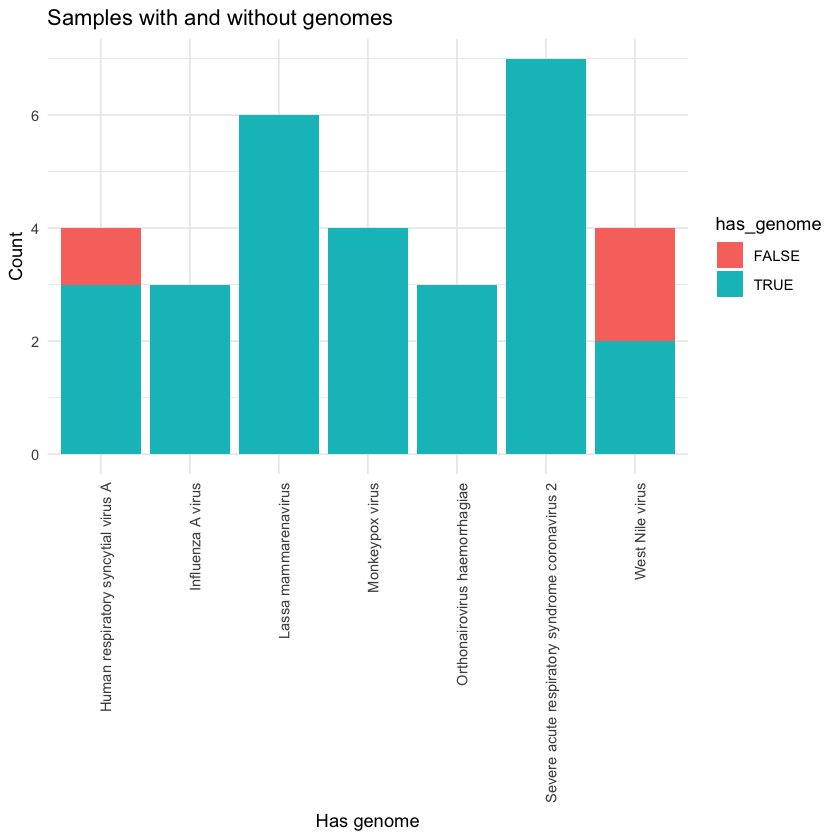

In [67]:
ggplot(df_samples%>% filter(!(sample%in% corrupted_runs)), aes(x=Organism_Name, fill=has_genome)) +
    geom_bar() +
    labs(title="Samples with and without genomes",
         x="Has genome",
         y="Count") +
    theme_minimal()+
theme(axis.text.x = element_text(angle = 90, hjust = 1))


Warning message:
“Removed 23 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 23 rows containing missing values or values outside the scale range
(`geom_point()`).”


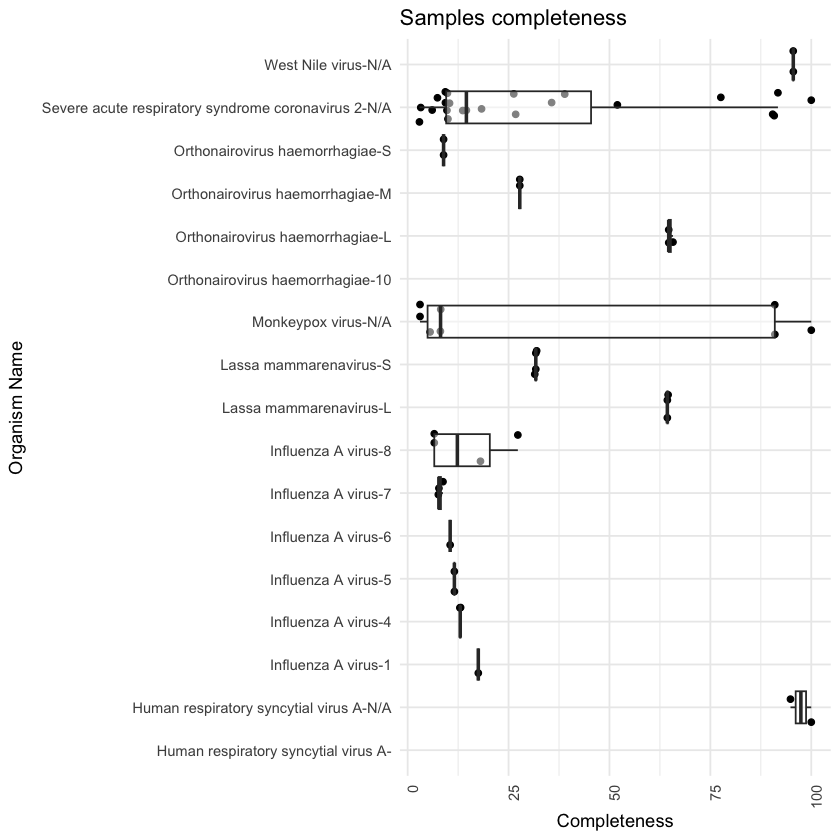

In [ ]:
ggplot(df_contigs%>% filter(!(sample%in% corrupted_runs))%>%
    mutate(species_segment= paste(Organism_Name,`X.annotation..segment`, sep="-")), aes(x=species_segment, y=completeness)) +
    geom_jitter() +
    geom_boxplot(outlier.shape = NA, alpha=0.5) +
    labs(title="Samples completeness",
         x="Organism Name",
         y="Completeness") +
    theme_minimal()+
theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
coord_flip()

`summarise()` has grouped output by 'sample'. You can override using the
`.groups` argument.


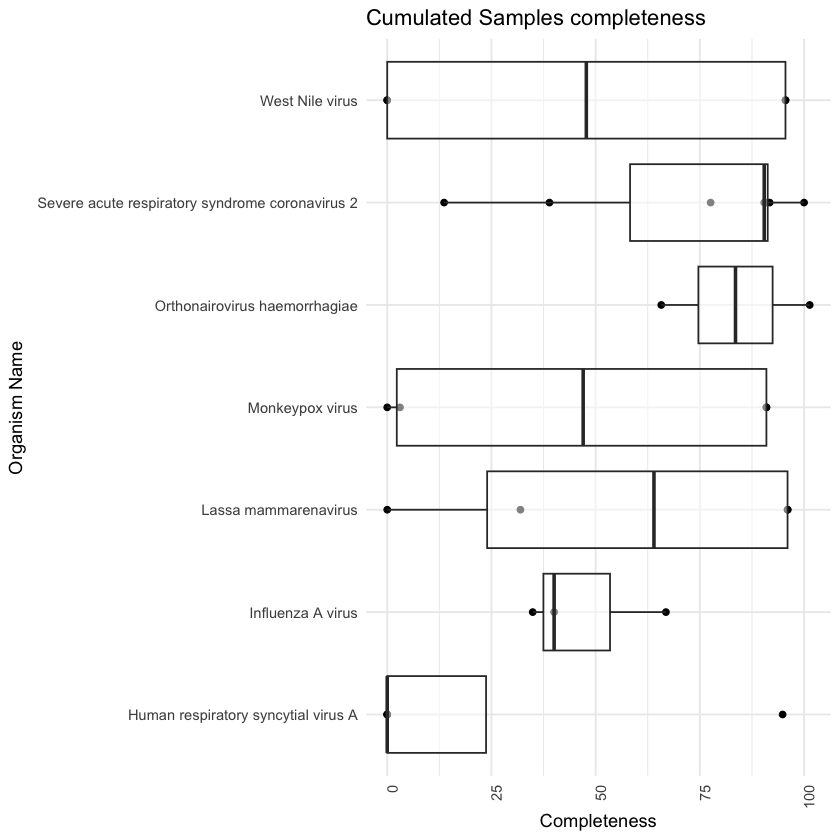

In [85]:
ggplot(df_contigs%>% filter(!(sample%in% corrupted_runs))%>%
    group_by(sample, Organism_Name,`X.annotation..segment`) %>%
    slice(1)%>%
    group_by(sample, Organism_Name)%>%
    summarise(completeness = sum(completeness, na.rm=TRUE)) %>%
    ungroup(), aes(x=Organism_Name, y=completeness)) +
    geom_point() +
    geom_boxplot(outlier.shape = NA, alpha=0.5) +
    labs(title="Cumulated Samples completeness",
         x="Organism Name",
         y="Completeness") +
    theme_minimal()+
theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
coord_flip()

In [9]:
df_contigs%>% filter(!(sample%in% corrupted_runs))%>%
    group_by(sample, Organism_Name,`X.annotation..segment`) %>%
    slice(1)%>%
    group_by(sample, Organism_Name)%>%
    summarise(completeness = sum(completeness, na.rm=TRUE)) %>%
    ungroup()%>%
    arrange(Organism_Name, completeness)

`summarise()` has grouped output by 'sample'. You can override using the
`.groups` argument.


sample,Organism_Name,completeness
<chr>,<chr>,<dbl>
ERX13777354,Human respiratory syncytial virus A,0.00
SRX27887901,Human respiratory syncytial virus A,0.00
SRX28439211,Human respiratory syncytial virus A,0.00
SRX27284000,Human respiratory syncytial virus A,94.85
SRX26211983,Influenza A virus,34.90
SRX27181532,Influenza A virus,40.04
SRX27315411,Influenza A virus,66.86
SRX20230124,Lassa mammarenavirus,0.00
SRX1617782,Lassa mammarenavirus,31.96


In [ ]:
# Summary statistics for manuscript
results_summary <- df_contigs %>%
  filter(!(sample %in% corrupted_runs)) %>%
  group_by(sample, Organism_Name, `X.annotation..segment`) %>%
  slice(1) %>%
  group_by(sample, Organism_Name) %>%
  summarise(completeness = sum(completeness, na.rm=TRUE)) %>%
  ungroup() %>%
  group_by(Organism_Name) %>%
  summarise(
    n_samples = n(),
    success_rate = mean(completeness > 50),
    high_quality_rate = mean(completeness > 90),
    mean_completeness = mean(completeness),
    median_completeness = median(completeness)
  ) %>%
  arrange(desc(success_rate))

print("Summary by organism:")
print(results_summary)

# Overall statistics
overall_stats <- df_contigs %>%
  filter(!(sample %in% corrupted_runs)) %>%
  group_by(sample, Organism_Name, `X.annotation..segment`) %>%
  slice(1) %>%
  group_by(sample, Organism_Name) %>%
  summarise(completeness = sum(completeness, na.rm=TRUE)) %>%
  ungroup() %>%
  summarise(
    total_samples = n(),
    successful_reconstructions = sum(completeness > 50),
    high_quality_reconstructions = sum(completeness > 90),
    success_rate = mean(completeness > 50),
    high_quality_rate = mean(completeness > 90)
  )

print("\nOverall statistics:")
print(overall_stats)

`summarise()` has grouped output by 'sample'. You can override using the
`.groups` argument.


[1] "Summary by organism:"
# A tibble: 7 × 6
  Organism_Name       n_samples success_rate high_quality_rate mean_completeness
  <chr>                   <int>        <dbl>             <dbl>             <dbl>
1 Orthonairovirus ha…         2        1                 0.5                83.6
2 Severe acute respi…         7        0.714             0.571              71.9
3 Lassa mammarenavir…         4        0.5               0.5                56.0
4 Monkeypox virus             4        0.5               0.5                46.2
5 West Nile virus             4        0.5               0.5                47.8
6 Influenza A virus           3        0.333             0                  47.3
7 Human respiratory …         4        0.25              0.25               23.7
# ℹ 1 more variable: median_completeness <dbl>


`summarise()` has grouped output by 'sample'. You can override using the
`.groups` argument.


[1] "\nOverall statistics:"
# A tibble: 1 × 5
  total_samples successful_reconstructions high_quality_reconstru…¹ success_rate
          <int>                      <int>                    <int>        <dbl>
1            28                         15                       12        0.536
# ℹ abbreviated name: ¹​high_quality_reconstructions
# ℹ 1 more variable: high_quality_rate <dbl>
